In [1]:
import argparse
import math
from pathlib import Path
import matplotlib
import torch
from torch.optim.lr_scheduler import StepLR
from SymNet import polypde
from SymNet.model_helper import *
import scvelo as scv
import scanpy
import scipy
import re
from torch.utils.data import DataLoader
from VeloAe.util import estimate_ld_velocity
from VeloAe.veloproj import *
from VeloAe.model import *
from VeloAe.eval_util import evaluate
from utils import PairsDataset, print_eqs, get_state_change_vector, SinkhornDistance
import matplotlib.pyplot as plt


In [2]:
parser = get_parser()
args = parser.parse_args(args=['--lr', '5e-6',
                               '--n-epochs', '20000',
                               '--g-rep-dim', '100',
                               '--k-dim', '100',
                               '--output', './pretrain_model/',
                               '--model-name', 'greenleaf3.cpt',
                               '--exp-name', 'CohAE_multiome',
                               '--device', ':5',
                               '--gumbsoft_tau', '5',
                               '--nb_g_src', "SU",
                               '--n_raw_gene', '954',
                              ])

In [3]:
device = torch.device("cuda" + args.device if torch.cuda.is_available() else "cpu")
seed = args.seed
torch.cuda.manual_seed_all(seed)
torch.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
Path(args.output).mkdir(parents=True,exist_ok=True)

In [4]:
adata = scanpy.read('./data/greenleaf_multiome/greenleaf_multivelo_0525.h5ad')
cluster_edges = [("Cyc.", "RG/Astro"), ("Cyc.", "mGPC/OPC"), ("Cyc.", "nIPC/ExN"), ("nIPC/ExN", "ExM"), ("ExM", "ExUp")]
k_cluster = "cluster"
chromatin = adata.layers['Mc']
chromatin = chromatin.todense()
tensor_c = torch.DoubleTensor(chromatin).to(device)
tensor_all = [tensor_c]
channel_names = 'u, s, c'

pretrain veloAE

In [7]:
def main_AE(args, adata):
    spliced = adata.layers['Ms']
    unspliced = adata.layers['Mu']
    tensor_s = torch.DoubleTensor(spliced).to(device)
    tensor_u = torch.DoubleTensor(unspliced).to(device)
    #tensor_x = torch.DoubleTensor(adata.X).to(device)
    tensor_c = torch.DoubleTensor(adata.layers['Mc'].todense()).to(device)
    model, _ = init_model(adata, args, device)
    model = model.to(device, dtype=torch.float64)

    inputs = [tensor_s, tensor_u, tensor_c]
    xyids = [0, 1, 2]
    if args.use_x:
        inputs.append(tensor_x)

    model = fit_model(args, adata, model, inputs, xyids, device)
    return tensor_s, tensor_u, tensor_c

computing neighbors
    finished (0:00:13) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
Train Epoch: 100/20000 	Loss: 72.898278
Train Epoch: 200/20000 	Loss: 32.975551
Train Epoch: 300/20000 	Loss: 30.671563
Train Epoch: 400/20000 	Loss: 30.533689
Train Epoch: 500/20000 	Loss: 30.468678
Train Epoch: 600/20000 	Loss: 30.427857
Train Epoch: 700/20000 	Loss: 30.393297
Train Epoch: 800/20000 	Loss: 30.363746
Train Epoch: 900/20000 	Loss: 30.339570
Train Epoch: 1000/20000 	Loss: 30.312282
Train Epoch: 1100/20000 	Loss: 30.283602
Train Epoch: 1200/20000 	Loss: 30.249515
Train Epoch: 1300/20000 	Loss: 30.210402
Train Epoch: 1400/20000 	Loss: 30.168476
Train Epoch: 1500/20000 	Loss: 30.132370
Train Epoch: 1600/20000 	Loss: 30.105523
Train Epoch: 1700/20000 	Loss: 30.086093
Train Epoch: 1800/20000 	Loss: 30.06

Train Epoch: 19300/20000 	Loss: 29.106824
Train Epoch: 19400/20000 	Loss: 29.102678
Train Epoch: 19500/20000 	Loss: 29.113882
Train Epoch: 19600/20000 	Loss: 29.112348
Train Epoch: 19700/20000 	Loss: 29.101647
Train Epoch: 19800/20000 	Loss: 29.095714
Train Epoch: 19900/20000 	Loss: 29.094225
Train Epoch: 20000/20000 	Loss: 29.103853


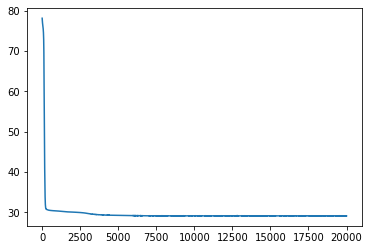

In [8]:
tensor_s, tensor_u, tensor_c = main_AE(args, adata)

eval

In [9]:
def exp(adata, exp_metrics):
    tensor_x = torch.DoubleTensor(adata.X).to(device)
    model, _ = init_model(adata, args, device)
    model.load_state_dict(torch.load(os.path.join(args.output,args.model_name)))
    model = model.to(device, dtype=torch.float64)
    model.eval()
    with torch.no_grad():
        x = model.encoder(tensor_x)
        s = model.encoder(tensor_s)
        u = model.encoder(tensor_u)
        c = model.encoder(tensor_c)
        
        v = estimate_ld_velocity(u, c, device=device).cpu().numpy()
        x = x.cpu().numpy()
        s = s.cpu().numpy()
        u = u.cpu().numpy()
    
    adata = new_adata(adata, x, s, u, v, g_basis="X")
    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.pl.velocity_embedding_stream(adata, legend_loc='right_margin', vkey="new_velocity", basis='X_umap', color=                                     [k_cluster],
                                    title="Project Original Velocity into Low-Dim Space", smooth=0.5,
                                    dpi=350,
                                    save=args.output + 'Multiome_veloae.png')  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Cohort AutoEncoder'] = evaluate(adata, cluster_edges, k_cluster, "new_velocity")
    return exp_metrics

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocity graph (using 1/64 cores)



    finished (0:00:03) --> added 
    'new_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'new_velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ./pretrain_model/Multiome_veloae.png


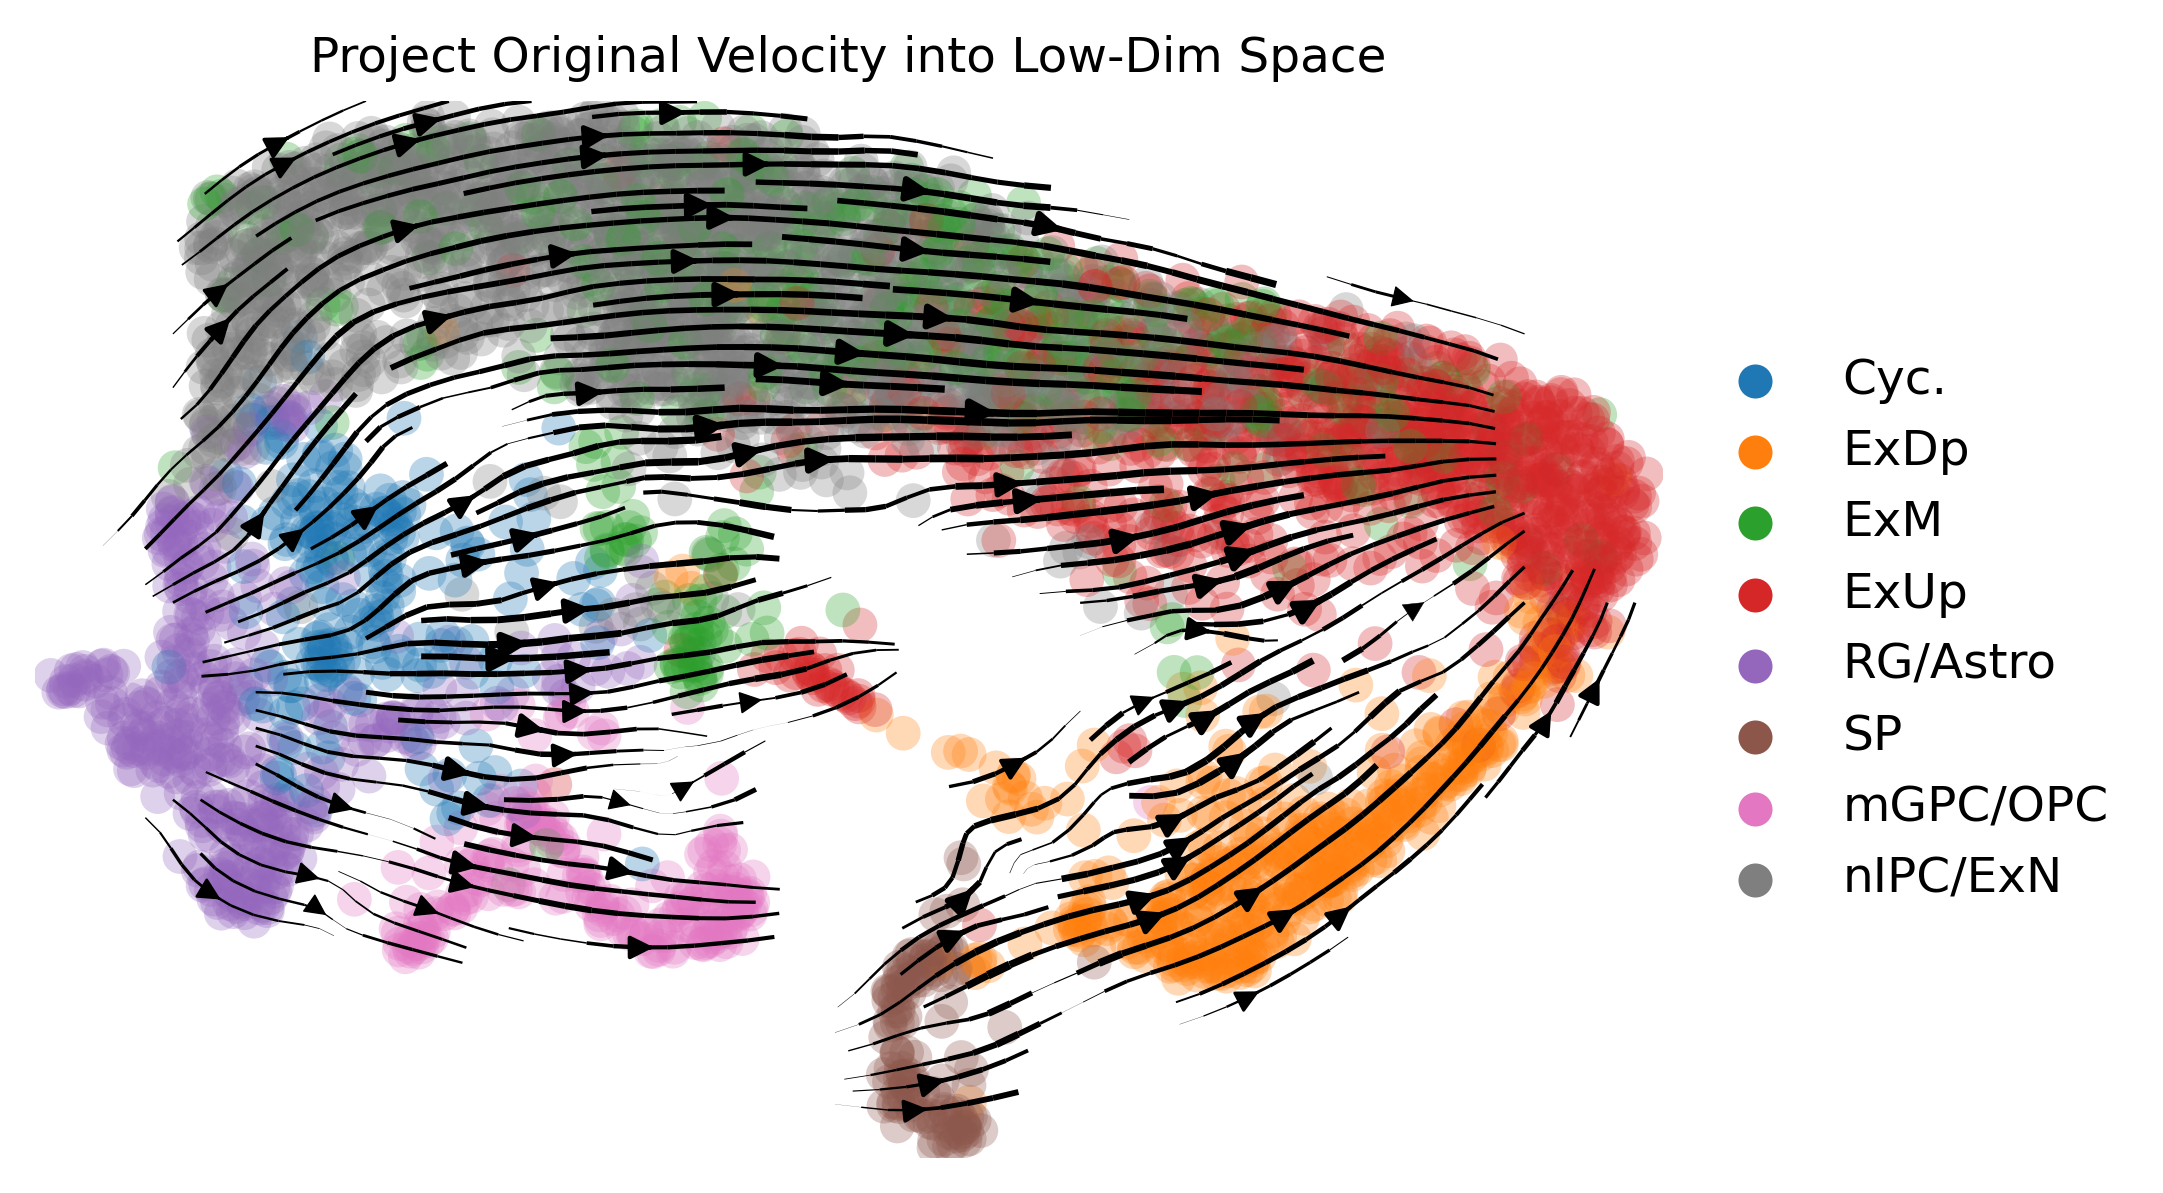

--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)
# Cross-Boundary Transition Score (A->B)
{('Cyc.', 'RG/Astro'): 0.34694797, ('Cyc.', 'mGPC/OPC'): 0.39257345, ('Cyc.', 'nIPC/ExN'): 0.5242424, ('nIPC/ExN', 'ExM'): 0.32397988, ('ExM', 'ExUp'): 0.5085172}
Total Mean: 0.4192521572113037
# Cross-Boundary Velocity Coherence (A->B)
{('Cyc.', 'RG/Astro'): 0.9998896759560335, ('Cyc.', 'mGPC/OPC'): 0.9996288320925922, ('Cyc.', 'nIPC/ExN'): 0.9998560631832968, ('nIPC/ExN', 'ExM'): 0.9998594178441981, ('ExM', 'ExUp'): 0.9998329629730035}
Total Mean: 0.9998133904098248
# Cross-Boundary Direction Correctness (A->B)
{('Cyc.', 'RG/Astro'): -0.4343399092606465, ('Cyc.', 'mGPC/OPC'): 0.2928472385735441, ('Cyc.', 'nIPC/ExN'): 0.3363767543403664, ('nIPC/ExN', 'ExM'): 0.18611365729741502, ('ExM', 'ExUp'): 0.46207038172786147}
Total Mean: 0.1686136245357081
# In-cluster Coherence
{'Cyc.': 0.99989216059418, 

In [10]:
exp_metrics = {}
result = exp(adata,exp_metrics)